In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import anndata as ad
import scanpy as sc

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP

from scroutines import powerplots
import time

import importlib
importlib.reload(powerplots)
from scroutines import basicu
from scroutines.miscu import is_in_polygon

import utils_merfish

In [2]:
np.random.seed(0)

In [3]:
def binning_pipe(adata, n=20, layer='lnorm', bin_type='depth_bin'):
    """
    """
    assert bin_type in ['depth_bin', 'width_bin']
    # bin it 
    depth_bins, depth_binned = utils_merfish.binning(adata.obs['depth'].values, n)
    width_bins, width_binned = utils_merfish.binning(adata.obs['width'].values, n)

    norm_ = pd.DataFrame(adata.layers[layer], columns=adata.var.index)
    norm_['depth_bin'] = depth_binned
    norm_['width_bin'] = width_binned
    
    norm_mean = norm_.groupby(bin_type).mean(numeric_only=True)
    norm_sem  = norm_.groupby(bin_type).sem(numeric_only=True)
    norm_std  = norm_.groupby(bin_type).std(numeric_only=True)
    norm_n    = norm_[bin_type].value_counts(sort=False)

    return norm_mean, norm_sem, norm_std, norm_n, depth_binned, width_binned, depth_bins, width_bins

In [4]:
outdir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240228"
outdatadir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish"
!mkdir -p $outdir

In [5]:
from merfish_datasets import merfish_datasets
from utils_merfish import rot2d
import json

directories = merfish_datasets
print(merfish_datasets)

name = 'P28NR_pos'
dirc = directories[name]



{'P14NR_ant': 'merfish_06142023/ant/region0', 'P28NR_ant': 'merfish_06142023/ant/region1', 'P14NR_pos': 'merfish_06142023/pos/region0', 'P28NR_pos': 'merfish_06142023/pos/region1', 'P21NR_ant': 'merfish_20231114/region0', 'P21DR_ant': 'merfish_20231114/region2', 'P28DR_ant': 'merfish_20231114/region1', 'P21NR_pos': 'merfish_20231120/region0', 'P21DR_pos': 'merfish_20231120/region1', 'P28DR_pos': 'merfish_20231120/region2'}


In [6]:
f_main = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/{name}_ctxglut_240411.h5ad'
f_spot = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/{dirc}/detected_transcripts_v1l23fovs.csv'

df_v1l23 = pd.read_csv(f_spot) # , nrows=1000)
print(len(df_v1l23))

adata = ad.read(f_main)
print(len(adata))

rotation_angle = adata.uns['rotation']
ref_line = np.array(adata.uns['ref_line'])
bound_l, bound_r, bound_d = adata.uns['bound_lrd']
cond = np.all([
    adata.obs['width'] > bound_l, 
    adata.obs['width'] < bound_r, 
    adata.obs['depth'] < bound_d, 
], axis=0)
adatasub = adata[cond]

print(len(adatasub))
print(rotation_angle)
print(ref_line.shape)

ref_line_obj = utils_merfish.RefLineSegs(ref_line)

3547091
25253
3696
-90
(100, 2)


In [7]:
query_genes = ['Cdh13', 'Sorcs3', 'Chrm2']
abc = df_v1l23[df_v1l23['gene'].isin(query_genes)].copy()

x = abc['global_x'].values
y = abc['global_y'].values
xr, yr = rot2d(x, y, rotation_angle)
XY = np.vstack([xr, yr]).T 
print(len(abc))

abc['x'] = xr
abc['y'] = yr
abc['depth'] = ref_line_obj.ndist_to_qps(XY)
abc['width'] = ref_line_obj.tdist_to_qps(XY)


cond_spots = np.all([
    abc['width'] > bound_l, 
    abc['width'] < bound_r, 
    abc['depth'] < bound_d, 
], axis=0)

abc = abc[cond_spots]
print(len(abc))
abc.value_counts('gene').reindex(query_genes) 

7583
4884


gene
Cdh13      785
Sorcs3    2728
Chrm2     1371
dtype: int64

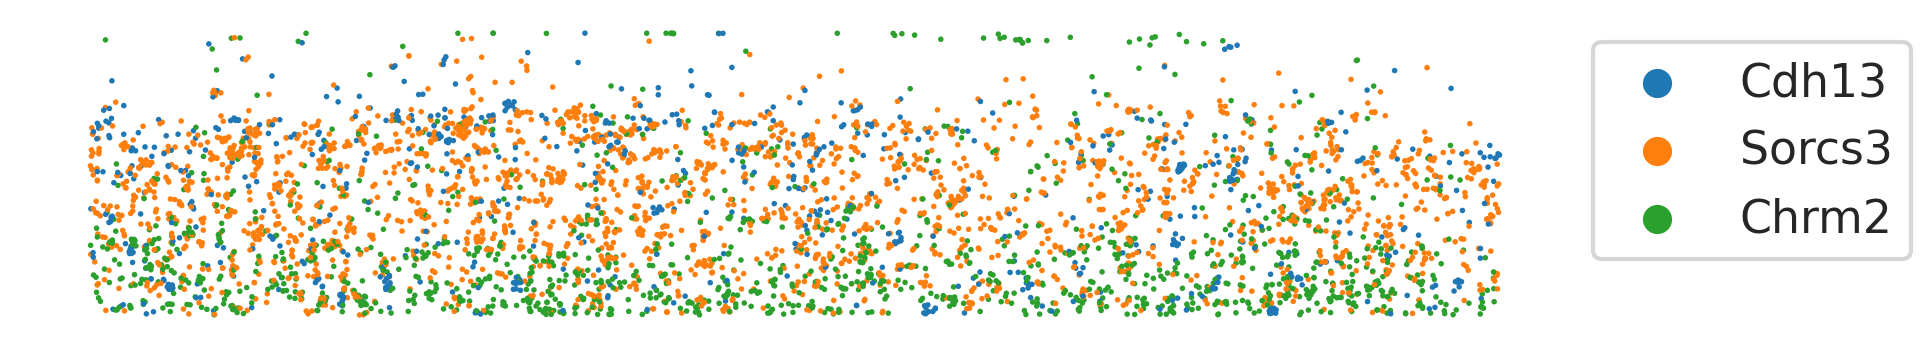

In [8]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                x='width', y='depth', hue='gene', hue_order=query_genes, 
                s=4, edgecolor='none', ax=ax, )
ax.set_aspect('equal')
ax.axis('off')
ax.legend(bbox_to_anchor=(1,1))
ax.invert_yaxis()

<Axes: ylabel='Count'>

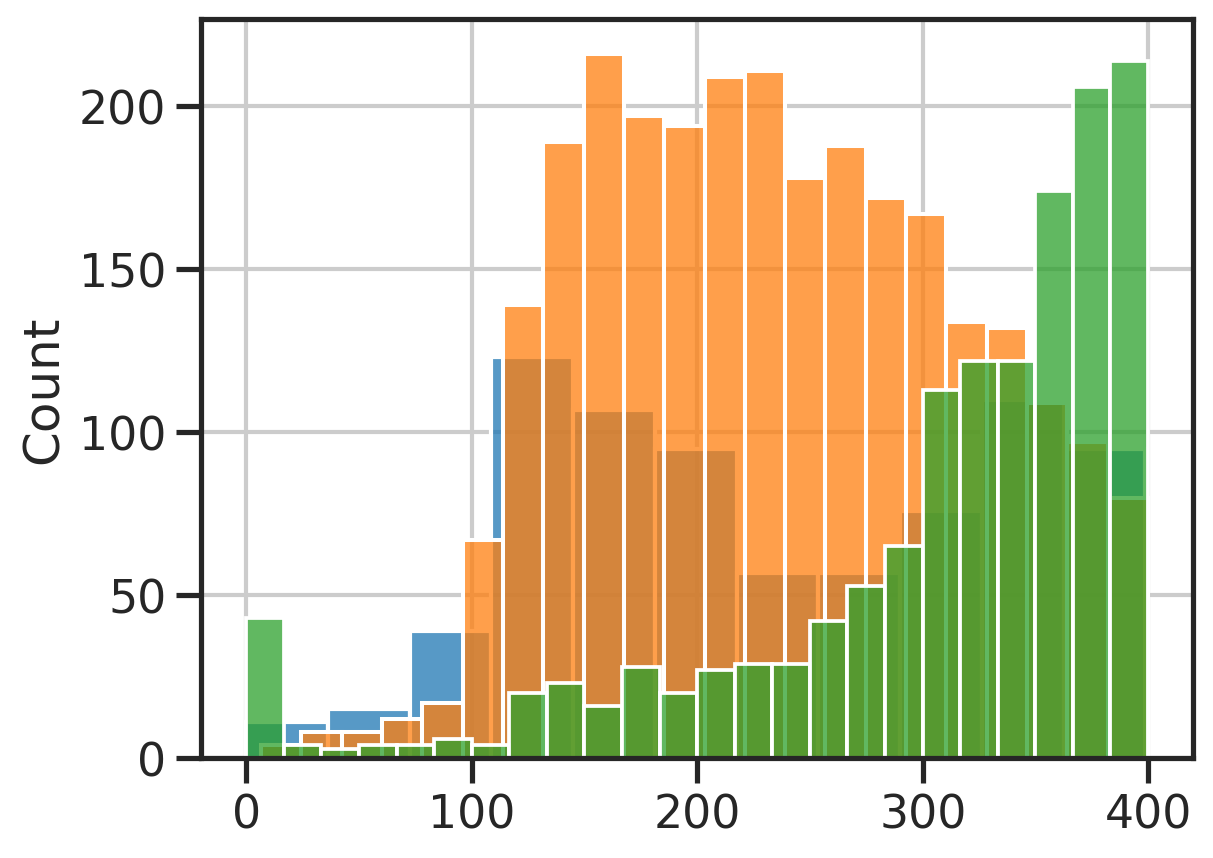

In [9]:
d = abc[abc['gene']=='Cdh13']['depth']
sns.histplot(d.values)
d = abc[abc['gene']=='Sorcs3']['depth']
sns.histplot(d.values)
d = abc[abc['gene']=='Chrm2']['depth']
sns.histplot(d.values)